# Etapa 6:  Predicción mediante aprendizaje automático

Space X anuncia en su página web lanzamientos de cohetes Falcon 9 con un coste de 62 millones de dólares; otros proveedores cuestan más de 165 millones de dólares cada uno, gran parte del ahorro se debe a que Space X puede reutilizar la primera etapa. Por lo tanto, si podemos determinar si la primera etapa aterrizará, podemos determinar el coste de un lanzamiento. Esta información puede utilizarse si una empresa alternativa quiere pujar contra Space X por el lanzamiento de un cohete.   En este laboratorio, crearás una línea de aprendizaje automático para predecir si la primera etapa aterrizará dados los datos de los laboratorios anteriores.

## Objetivos

Realizar un análisis exploratorio de los datos y determinar las etiquetas de formación

* Crear una columna para la clase
* Estandarizar los datos
* Dividir en datos de entrenamiento y datos de prueba

\-Encontrar el mejor hiperparámetro para SVM, árboles de clasificación y regresión logística

* Encontrar el método que mejor se comporta utilizando los datos de prueba


***


## Importar librerias y Definir Funciones Auxiliares


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

Esta función sirve para visualizar la matriz de confusión.


In [2]:
def plot_confusion_matrix(y,y_predict):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); 
    ax.set_xlabel('Valores predecidos')
    ax.set_ylabel('Valores reales')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['no aterrizó', 'aterrizó']); ax.yaxis.set_ticklabels(['no aterrizó', 'aterrizó'])

## Cargar el dataframe


Cargar los datos


In [3]:
data = pd.read_csv("dataset_part_2.csv")
data.head()

,Unnamed: 0,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


Al conjunto de datos anterior hemos aplicado una transformación one-hot para poder realizar las tareas de machine learning correctamente

In [4]:
X = pd.read_csv('dataset_one-hot.csv')

X.head(100)

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,0,0,0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1,1,1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,2,2,2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,3,3,3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,4,4,4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,85,85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,86,86,86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,87,87,87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,88,88,88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## Tarea  1


Crea un array NumPy a partir de la columna `Class` en `data`, aplicando el método `to_numpy()` y luego
asignarlo a la variable `Y`, asegúrese de que la salida es una serie Pandas (sólo un paréntesis df\['nombre de la columna'\]).

In [5]:
Y = data['Class'].to_numpy()

## Tarea  2


Normalice los datos en `X` usando al función `fit_transform` y luego reasígnelos a la variable `X` utilizando la transformación proporcionada a continuación.


In [6]:
scaler = preprocessing.StandardScaler()

In [7]:
X = scaler.fit_transform(X)

Dividimos los datos en datos de entrenamiento y de prueba utilizando la función `train_test_split`.   Los datos de entrenamiento se dividen en datos de validación, un segundo conjunto utilizado para los datos de entrenamiento; luego se entrenan los modelos y se seleccionan los hiperparámetros utilizando la función `GridSearchCV`.


## Tarea  3


Utilice la función `train_test_split` para dividir los datos X e Y en datos de entrenamiento y de prueba como hicimos en la práctica de regresión. Establezca el parámetro test_size en 0,2 y random_state en 2. Los datos de entrenamiento y los datos de prueba deben asignarse a las siguientes etiquetas.


`X_train, X_test, Y_train, Y_test`


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Tarea  4


* Cree un objeto de regresión logística. 
* Luego crea un objeto GridSearchCV `logreg_cv` con el objeto de regresión lógistica, los parametros descritos, `scoring='accuracy'` y `cv = 10`.  
* Ajusta el objeto GridSearchCV para encontrar los mejores parámetros del diccionario `parameters`.


In [9]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [10]:
logreg = LogisticRegression()
logreg_cv = GridSearchCV(
    estimator=logreg,
    scoring='accuracy',
    param_grid=parameters,
    cv= 10
)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='accuracy')

Mostramos los mejores parámetros utilizando el atributo de datos `best_params_` y la precisión en los datos de validación utilizando el atributo de datos `best_score_`.


In [11]:
print("Mejores parámetros ", logreg_cv.best_params_)
print("Precisión de la regresión logística:", logreg_cv.best_score_)

Mejores parámetros  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Precisión de la regresión logística: 0.7928571428571429


## Tarea  5


Calcule la precisión en los datos de prueba utilizando el método `score`sobre `X_test` e `Y_test`:


In [12]:
print(f'Precisión de la resgresión logística mediante el método score: {logreg_cv.score(X_test, Y_test)}')

Precisión de la resgresión logística mediante el método score: 1.0


Predice `X_test` y guardalo en `y_pred`

In [13]:
y_pred = logreg_cv.predict(X_test)

Compara `y_pred` con `Y_test` con una matriz de confusión:

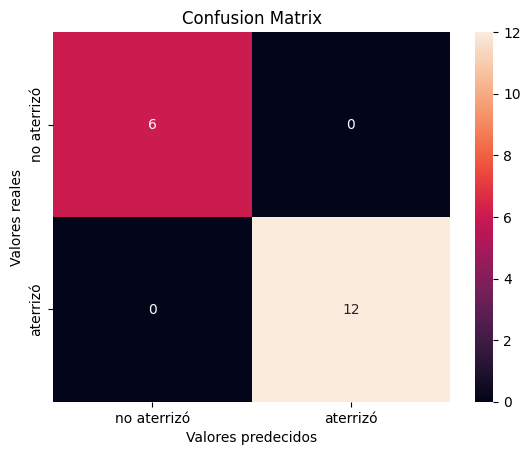

In [14]:
plot_confusion_matrix(Y_test, y_pred)

Al examinar la matriz de confusión, vemos que la regresión logística puede distinguir entre las diferentes clases.  Vemos que el principal problema son los falsos positivos.


## Tarea  6


* Crea un objeto [Support Vector Machine](https://scikit-learn.org/stable/modules/svm.html) y guardalo en svm 
* Luego crea un objeto `GridSearchCV` `svm_cv` con el objeto de svm, los parametros descritos, `scoring='accuracy'` y  `cv=10`.  
* Ajusta el objeto para encontrar los mejores parámetros del diccionario `parameters`.


In [15]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}

In [16]:
svm = SVC()
svm_cv = GridSearchCV(
    estimator=svm,
    scoring='accuracy',
    param_grid=parameters,
    cv=10
)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')},
             scoring='accuracy')

In [17]:
print("Mejores parámetros: ", svm_cv.best_params_)
print("Accuracy :", svm_cv.best_score_)

Mejores parámetros:  {'C': 1000.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Accuracy : 0.8053571428571429


## Tarea  7


Calcule la precisión en los datos de prueba utilizando el método `score`sobre `X_test` e `Y_test`:


In [18]:
print(f'Precisión de la máquina de vectores de apoyo en los datos de prueba mediante el método score: {svm_cv.score(X_test, Y_test)}')

Precisión de la máquina de vectores de apoyo en los datos de prueba mediante el método score: 0.8888888888888888


Podemos representar la matriz de confusión:

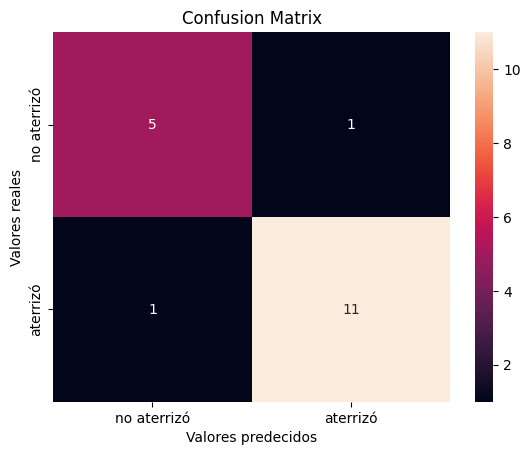

In [19]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## Tarea  8


* Crea un objeto clasificador de árbol de decisión
* Y luego crea un objeto GridSearchCV tree_cv con el objeto clasificador de árbol de decisión, los parametros descritos, `scoring='accuracy'` y  cv = 10.
* Ajuste el objeto para encontrar los mejores parámetros a partir de los parámetros del diccionario.

In [20]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

In [21]:
tree_classifier = DecisionTreeClassifier()
tree_cv = GridSearchCV(
    estimator=tree_classifier,
    scoring='accuracy',
    param_grid=parameters,
    cv=10
)

tree_cv.fit(X_train, Y_train)

C:\Users\esser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\esser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
C:\Users\esser\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [22]:
print("Mejores parámetros:", tree_cv.best_params_)
print("Accuracy for decision tree classifier:", tree_cv.best_score_)

Mejores parámetros: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
Accuracy for decision tree classifier: 0.8732142857142857


## Tarea  9


Calcula la precisión de tree_cv en los datos de prueba utilizando el método `score`:


In [23]:
print(f'Precisión del clasificador de árbol de decisión en los datos de prueba mediante el método score: {tree_cv.score(X_test, Y_test)}')

Precisión del clasificador de árbol de decisión en los datos de prueba mediante el método score: 0.9444444444444444


Podemos representar la matriz de confusión


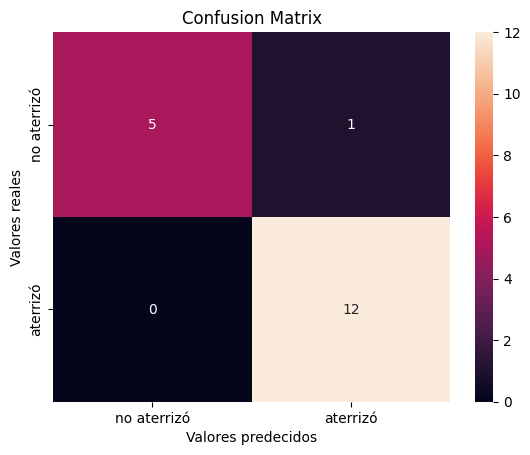

In [24]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## Tarea  10


* Crear un objeto k vecinos más cercanos 
* Y luego crear un objeto `GridSearchCV` `knn_cv` con el objeto k vecinos más cercanos, los parametros descritos, `scoring='accuracy'` y  cv = 10. 
* Ajuste el objeto para encontrar los mejores parámetros del diccionario `parameters`.


In [25]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

In [26]:
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(
    estimator=knn,
    scoring='accuracy',
    param_grid=parameters,
    cv=10
)

In [27]:
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]},
             scoring='accuracy')

In [28]:
print("Mejores parámetros: ",knn_cv.best_params_)
print("Accuracy for k nearest neighbors:",knn_cv.best_score_)

Mejores parámetros:  {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1}
Accuracy for k nearest neighbors: 0.7910714285714285


## Tarea  11


Calcula la precisión de knn_cv en los datos de prueba utilizando el método `score`:


In [29]:
print(f'Precisión del KNN en los datos de prueba mediante el método score: {knn_cv.score(X_test, Y_test)}')

Precisión del KNN en los datos de prueba mediante el método score: 0.8888888888888888


Podemos representar la matriz de confusión


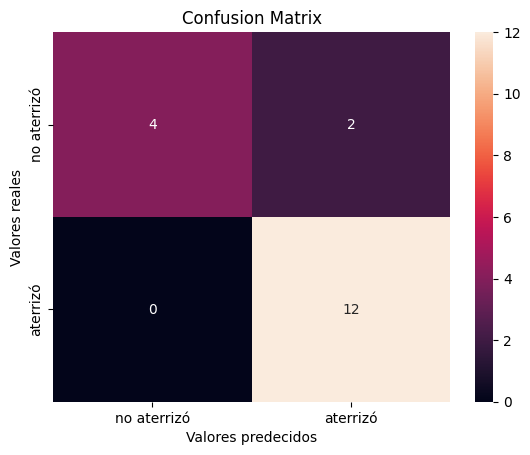

In [30]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## Tarea  12


Encuentra el método que mejor funciona. Para ello crea un dataframe con los los resultados y los algoritmos. Muestra los diferentes resultado en un gráfico de barras.

In [31]:
algorithms = {'KNN':knn_cv.best_score_,'Decision Tree':tree_cv.best_score_,'Logistic Regression':logreg_cv.best_score_,'SVM':svm_cv.best_score_}


In [32]:
algo_df = pd.DataFrame.from_dict(algorithms, orient='index', columns=['Accuracy'])

algo_df = algo_df.reset_index()
algo_df = algo_df.rename(mapper={'index':'Algorithm'}, axis = 1)


,Algorithm,Accuracy
0,KNN,0.791071
1,Decision Tree,0.873214
2,Logistic Regression,0.792857
3,SVM,0.805357


In [33]:
import plotly.express as px
import plotly.graph_objects as go
import nbformat

fig = px.bar(algo_df, x='Algorithm', y='Accuracy', hover_data=['Algorithm', 'Accuracy'], color='Accuracy', color_continuous_scale='rdylbu')
fig.update_layout(title='Algorithm vs. Accuracy', xaxis_title='Algorithm', yaxis_title='Accuracy' )
fig.show()